# Multilayer Perceptron (MLP)

## Libraries

Load the libraries.

In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from imblearn.under_sampling import RandomUnderSampler

## Data Preprocessing

Load the data.

In [103]:
data = pd.read_csv("data/000webhost_subset_classifed_featureExtracted.csv", error_bad_lines=False)

/var/folders/rx/w842_l9s7339g3yr05drhxs40000gn/T/ipykernel_22715/4053744535.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv("data/000webhost_subset_classifed_featureExtracted.csv", error_bad_lines=False)


Split the data into traning and testing sets.

In [130]:
X = data.drop(columns=["password", "strength", "length", "uppercase", "lowercase", "digits", "special", "consecutive_char_type_count", "cracking_time"])
y = data["strength"]

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# First, split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Then, split the training set again to create a validation set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Categorize the output.

In [131]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.fit_transform(y_val)
y_test_encoded = encoder.fit_transform(y_test)

## Model Construction and Evaluation

Build the model.

In [132]:
model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], )),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='softmax')
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 512)               5120      
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_61 (Dense)            (None, 256)               131328    
                                                                 
 dense_62 (Dense)            (None, 128)               32896     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 64)                8256      
                                                                 
 dense_64 (Dense)            (None, 32)               

Compile and fit the model. 

In [133]:
batch_size = 32
epochs = 50

# Create the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
training_history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
7868/7868 [==============================] - 17s 2ms/step - loss: 1.0170 - accuracy: 0.6200 - val_loss: 0.7732 - val_accuracy: 0.6926
Epoch 2/50
7868/7868 [==============================] - 19s 2ms/step - loss: 0.7638 - accuracy: 0.6844 - val_loss: 0.7143 - val_accuracy: 0.7018
Epoch 3/50
7868/7868 [==============================] - 23s 3ms/step - loss: 0.7363 - accuracy: 0.6918 - val_loss: 0.7001 - val_accuracy: 0.7056
Epoch 4/50
7868/7868 [==============================] - 21s 3ms/step - loss: 0.7252 - accuracy: 0.6937 - val_loss: 0.7061 - val_accuracy: 0.7007
Epoch 5/50
7868/7868 [==============================] - 19s 2ms/step - loss: 0.7217 - accuracy: 0.6939 - val_loss: 0.6957 - val_accuracy: 0.7079
Epoch 6/50
7868/7868 [==============================] - 19s 2ms/step - loss: 0.7161 - accuracy: 0.6970 - val_loss: 0.6944 - val_accuracy: 0.7068
Epoch 7/50
7868/7868 [==============================] - 18s 2ms/step - loss: 0.7146 - accuracy: 0.6969 - val_loss: 0.6988 - val_ac

Run the model on the validation set. 

In [134]:
val_loss, val_acc = model.evaluate(X_val, y_val_encoded)
print(f"Test accuracy: {val_acc:.4f}")

2914/2914 [==============================] - 3s 1ms/step - loss: 0.6873 - accuracy: 0.7067
Test accuracy: 0.7067


Save the model. 

In [135]:
model.save("mlp_model.h5")

# Analysis of the Model

Load the model. 

In [136]:
loaded_model = load_model("mlp_model.h5")

Create a diagram of the model.

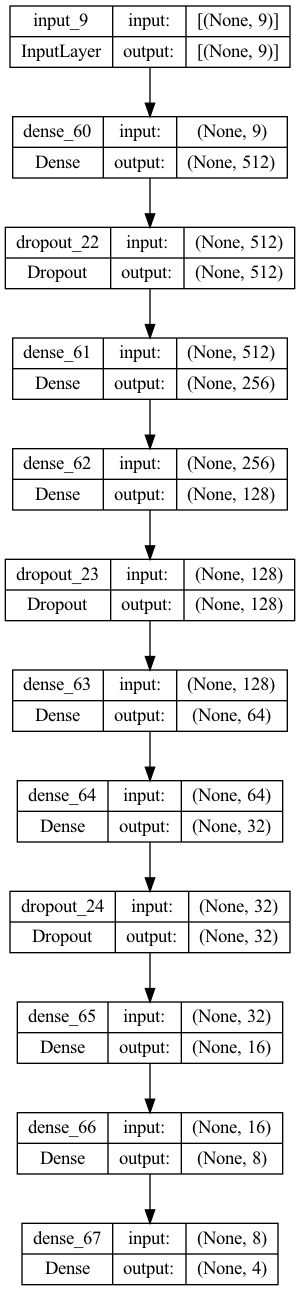

In [137]:
plot_model(loaded_model, to_file='MLP.png', show_shapes=True, show_layer_names=True)

Test the model.

In [138]:
test_loss, test_acc = loaded_model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_acc:.4f}")


2914/2914 [==============================] - 3s 1ms/step - loss: 0.6868 - accuracy: 0.7044
Test accuracy: 0.7044


Predict on the test set.

In [139]:
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

2914/2914 [==============================] - 3s 947us/step


Calculate different performance metrics.

In [140]:
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

Print the metrics.

In [141]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(classification_report(y_test_encoded, y_pred_classes))


Precision: 0.7357402861200959
Recall: 0.7043865293865293
F1-score: 0.7020994987064191
              precision    recall  f1-score   support

           0       0.71      0.64      0.67     23211
           1       0.57      0.81      0.67     23365
           2       0.78      0.85      0.81     23155
           3       0.89      0.52      0.66     23509

    accuracy                           0.70     93240
   macro avg       0.74      0.70      0.70     93240
weighted avg       0.74      0.70      0.70     93240



Find the ROC and AUC.

In [142]:
n_classes = 4
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Plot the ROC curve.

Macro-average AUC: 0.9077193751432211


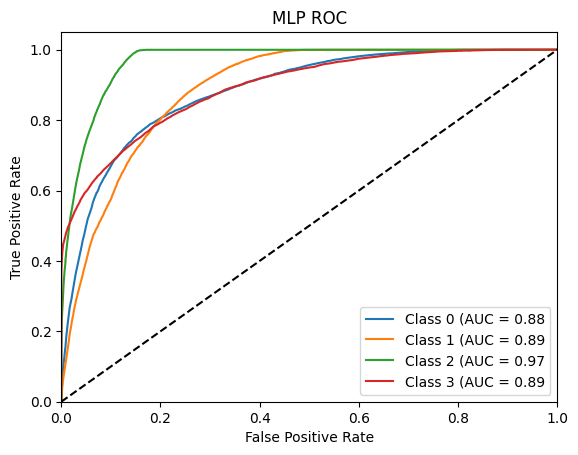

In [143]:
# Calculate the macro-average AUC
auc_macro = sum(roc_auc.values()) / len(roc_auc)
print("Macro-average AUC:", auc_macro)

# Plot the ROC curves with AUC values
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC')
plt.legend(loc="lower right")
plt.savefig("MLP ROC", dpi=300, bbox_inches='tight')
plt.show()


Rank the features by importance.

In [144]:
# Get the absolute values of the weights in the input layer
mlp_weights_abs = np.abs(loaded_model.layers[0].get_weights()[0])

# Sum the weights across neurons
mlp_feature_importance = np.sum(mlp_weights_abs, axis=1)

# Rank the features by their importance
mlp_feature_rank = np.argsort(mlp_feature_importance)[::-1]

print("MLP feature importance ranking:")
for i, rank in enumerate(mlp_feature_rank):
    print(f"Feature {rank}: {mlp_feature_importance[rank]:.4f}")


MLP feature importance ranking:
Feature 3: 125.9876
Feature 4: 123.4531
Feature 2: 115.9750
Feature 0: 106.7903
Feature 8: 106.1104
Feature 1: 72.7584
Feature 7: 46.5596
Feature 6: 41.9344
Feature 5: 25.4315


Plot the history. 

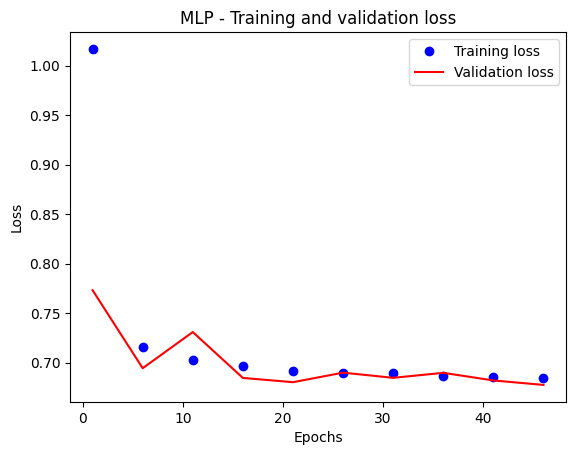

In [146]:
import matplotlib.pyplot as plt

def plot_loss(history, epoch_interval, model_name):
    epochs = range(1, len(history.history['loss']) + 1, epoch_interval)
    train_loss = history.history['loss'][::epoch_interval]
    val_loss = history.history['val_loss'][::epoch_interval]

    plt.figure()
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("MLP Training and Validation Loss", dpi=300, bbox_inches='tight')
    plt.show()
    
plot_loss(training_history, 5, 'MLP')

Plot a confusion matrix

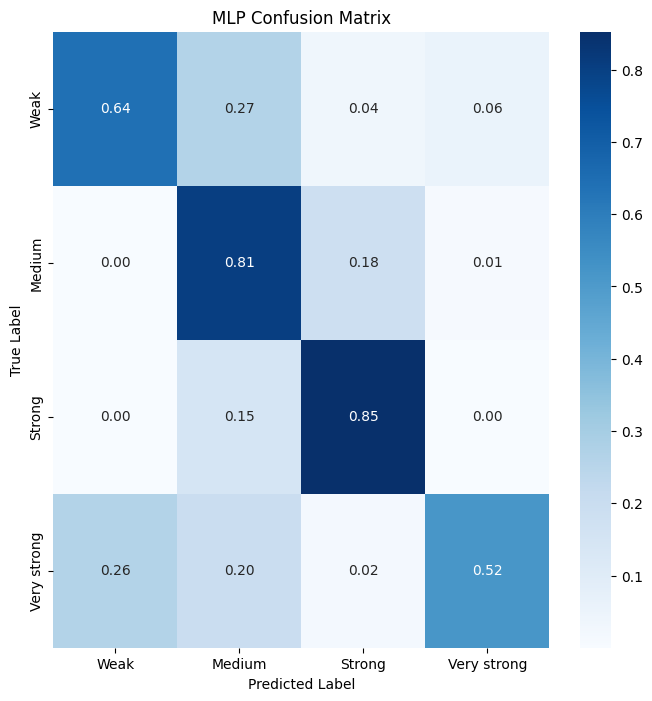

In [147]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('MLP Confusion Matrix')
    plt.savefig("MLP Confusion Matrix", dpi=300, bbox_inches='tight')
    plt.show()
    return(cm)
    
cm = plot_confusion_matrix(y_test_encoded, y_pred_classes, ['Weak', 'Medium', 'Strong', 'Very strong'])